In [28]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt

from simulate_planck_maps import simulate_planck_maps
from compute_cl import compute_cl
from compute_weights import compute_weights
from compute_alm_ilc import compute_alm_ilc

%matplotlib inline

Definitions

In [29]:
nside=128
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0,  545.0,  857.0])
n_freq = len(freqs)

Simulate maps using PySM

In [30]:
noise, dust, sync, ff, cmb = simulate_planck_maps(nside, freqs)

Combining the CMB and foreground maps to be input into ILC

In [31]:
maps_pl = cmb + noise + dust + sync + ff #cmb and foregrounds combined
fgds_pl= dust + sync + ff #combined foregrounds
print(maps_pl.shape)

(9, 196608)


Transforimng frequency maps to harmonic space by decomposition

In [32]:
#transform maps to spherical harmonics
lmax=3*nside -1 #default is lmax= 3*nside+1
alm_size=hp.Alm.getsize(lmax)
print(alm_size)
print((lmax+1)**2)
print(lmax)
alm_maps=np.zeros((n_freq, alm_size), dtype=complex) #storing coefficients in an array of dim n_freqs*almsize. dtype is complex to account for -ive values
alm_fgds= np.zeros((n_freq, alm_size), dtype=complex)
for nf in range(n_freq):
    alm_maps[nf,:]= hp.map2alm(maps_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False) #record alm corresponding to each f for a corresponding l and m
    alm_fgds[nf,:]= hp.map2alm(fgds_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False)

73920
147456
383


Compute nf x nf Covariance matrix by fixing $\ell$ for particular $a_{lm}$. Compute weights for every $\ell$

$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

In [33]:
alm_p, C_l=compute_cl(alm_maps, lmax, n_freq)
print(alm_p.shape)
print(C_l.shape)

(9, 384)
(384, 9, 9)


Now we can compute the inverse covariance matrix and compute the weights using $$\omega_i(l) = \frac{\sum_j (C_l^{-1})_{ij} b_{j}}{\sum_{ij}b_i (C_l^{-1})_{ij} b_{j}}$$

where $b_i $ represents the CMB transfer function. $b_i = [1,...,1]$

In [34]:
cl_inv, w = compute_weights(n_freq, lmax, C_l)
print(cl_inv.shape)
print(w.shape) #nf x m array

(9, 9)
(9, 384)


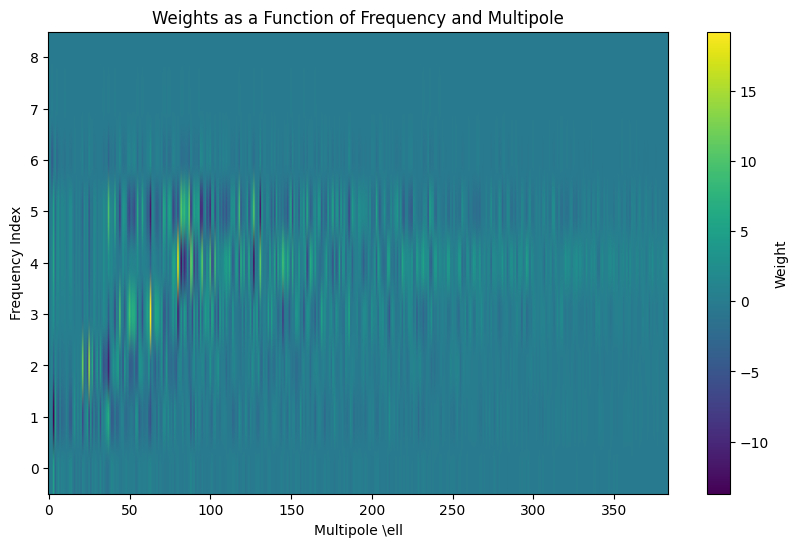

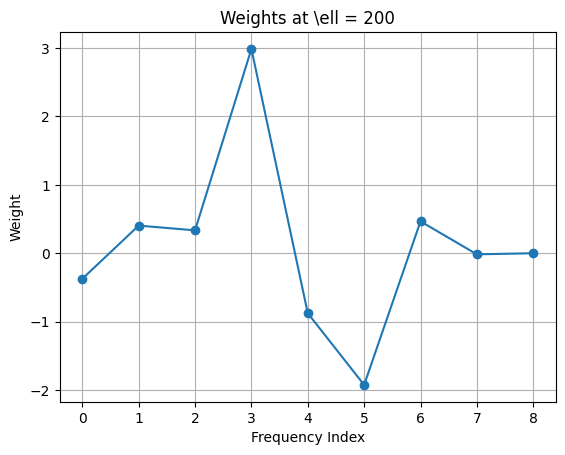

In [35]:
plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label="Weight")
plt.xlabel("Multipole \\ell")
plt.ylabel("Frequency Index")
plt.title("Weights as a Function of Frequency and Multipole")
plt.show()


plt.plot(range(n_freq), w[:, 200], marker='o', linestyle='-')

plt.xlabel("Frequency Index")
plt.ylabel("Weight")
plt.title(f"Weights at \\ell = {200}")
plt.grid()

Sum over frequencies to get $a_{ILC}$ for every $\ell$ weighted sum across all frequencies for each $m$ to get a cleaned spherical harmonic coefficient $a_{lm}$ for each $m$ at a given $\ell$.

$$a^{ILC}_{lm} = \sum_i w_i(l)a^i_{lm}$$

In [36]:
alm_ilc=compute_alm_ilc(alm_maps, alm_size, w, lmax)
print(alm_ilc.shape)

(73920,)


Converting back to pixel space

In [37]:
maps_out = hp.alm2map(alm_ilc, nside, lmax=lmax, mmax=None)
print(maps_out.shape)

(196608,)


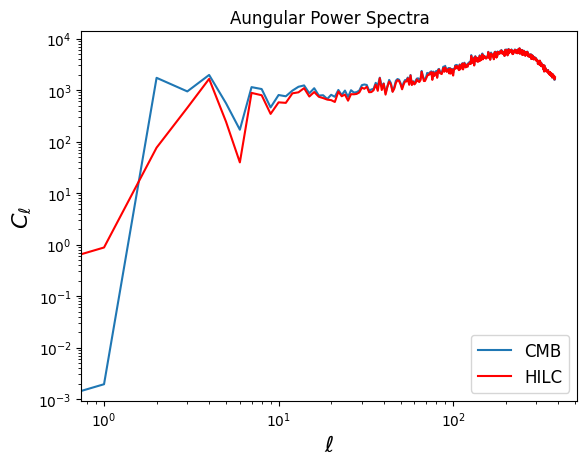

In [38]:
ells =np.arange(lmax+1)
norm= (ells*(ells+1))/(2*np.pi)

ilc =maps_out-np.mean(maps_out)

cl_cmb =hp.anafast(cmb[0])
cl_ilc = hp.anafast(ilc)
plt.plot(ells, norm*cl_cmb, label='CMB')
plt.plot(ells, norm*cl_ilc, 'r-',label= 'HILC')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.title('Aungular Power Spectra')
plt.legend(fontsize=12)
plt.show()

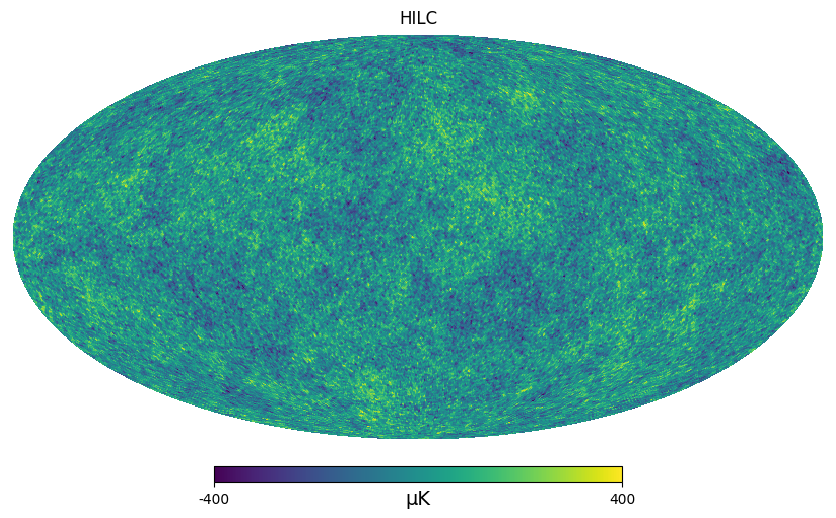

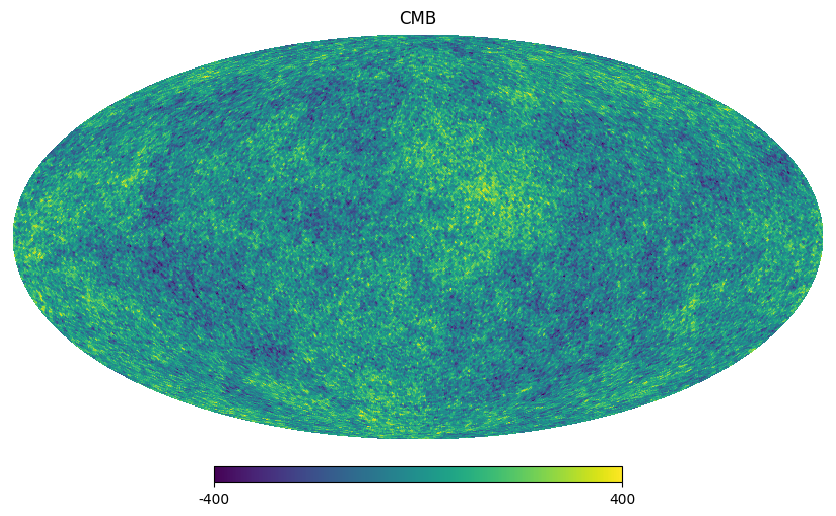

In [39]:
hp.mollview(ilc, title= "HILC", min=-400, max=400, unit ="μK")
hp.mollview(cmb[0],title ="CMB", min=-400, max=400)